In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import chainer
from dataset_4channel import RotatedSquaresDataset, BeetleDataset
import matplotlib.pyplot as plt
import numpy as np
import functions_rotation as fr 
from tests import *
from chainer import cuda 
import cupy
from chainer.optimizers import MomentumSGD,Adam 

#db = RotatedSquaresDataset()

Excellent, now let's initialize the network.

In [3]:
from Network_4channel import VGGNet
net = VGGNet()
net.to_gpu(0)

# Optimizer
# optimizer =MomentumSGD(lr= 0.05)
optimizer = Adam(alpha= 0.0001)
optimizer.setup(net)

In [4]:
raw_files = ['raw_densebox_1', 'raw_densebox_2', 'raw_densebox_3', 'raw_densebox_4', 'raw_densebox_5']
label_files = ['class_lab_densebox_1', 'class_lab_densebox_2', 'class_lab_densebox_3', 'class_lab_densebox_4', 'class_lab_densebox_5']

db = BeetleDataset(raw_files, label_files)
#db = RotatedSquaresDataset()

x_b,y_b,x_thresh_b=db.generate_batch(n=5)
print(x_b.shape)
#db.visualize_batch(x_b,y_b)
# Why is the magnification non uniform? Huh Huh HUH?

(5, 3, 240, 240)


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:
x_b.dtype

dtype('float32')

Let's begin the training process.

  0%|          | 0/500 [00:00<?, ?it/s]

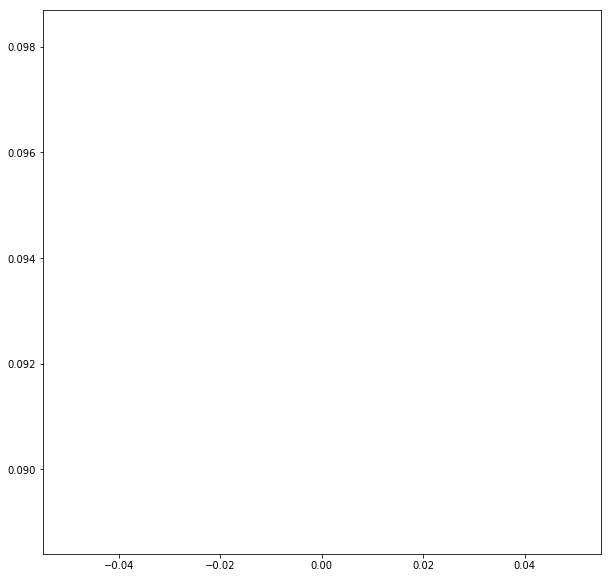

 10%|█         | 50/500 [00:28<04:17,  1.75it/s]

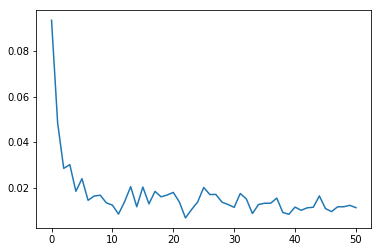

 20%|██        | 100/500 [00:54<03:32,  1.89it/s]

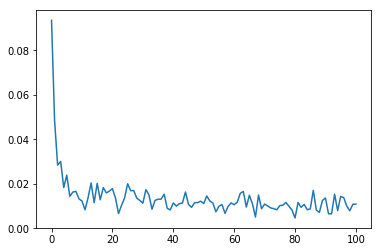

 30%|███       | 150/500 [01:20<03:05,  1.89it/s]

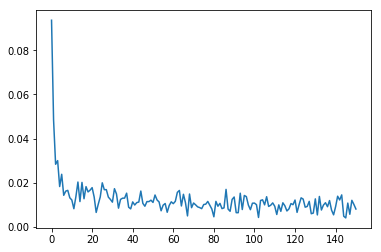

 40%|████      | 200/500 [01:46<02:42,  1.85it/s]

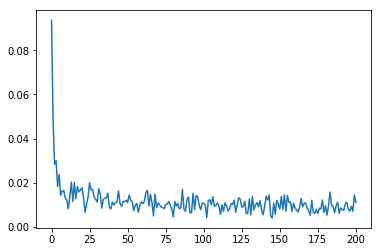

 50%|█████     | 250/500 [02:11<02:18,  1.80it/s]

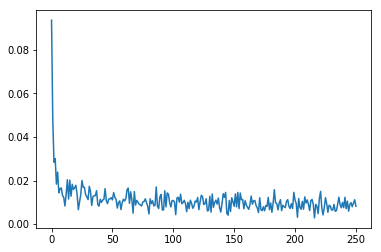

 60%|██████    | 300/500 [02:38<01:46,  1.88it/s]

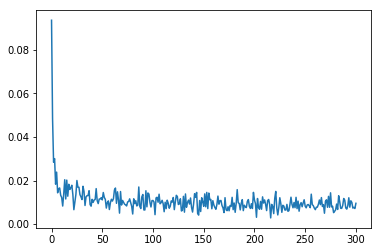

 70%|███████   | 350/500 [03:03<01:19,  1.89it/s]

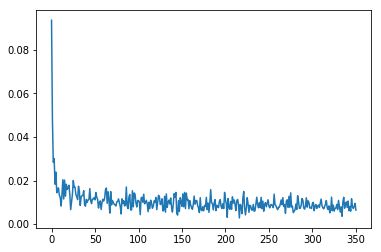

 80%|████████  | 400/500 [03:31<00:52,  1.91it/s]

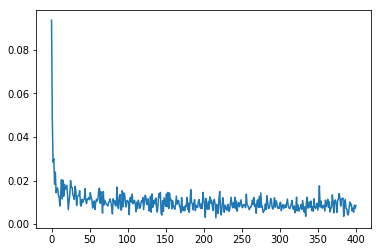

 90%|█████████ | 450/500 [03:57<00:22,  2.20it/s]

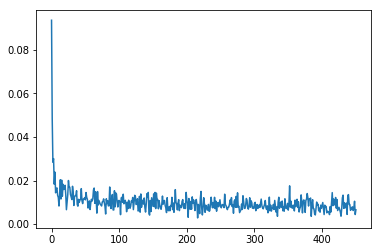

100%|██████████| 500/500 [04:22<00:00,  2.00it/s]


In [6]:
from tqdm import tqdm
losses = []

plt.figure(figsize=(10,10))
norm_factor = 25.0 # We'll normalize the offsets by the largest side and then multiply the shift vector by this factor

# Training for loop
for i in tqdm(range(500)):
    imgs, labels, imgs_thresh = db.generate_batch(n=5)
    imgs_down, labels_down, imgs_thresh_down = fr.downsample(imgs, labels, imgs_thresh)
    
    net.to_gpu(0)

    imgs_gpu = chainer.Variable(cuda.to_gpu(imgs)) #gpu
    
    gt_class, gt_loc = fr.encode_y(imgs_down,norm_factor , labels_down, imgs_thresh_down) #cpu
    
    # Pass the ground truths to the gpu
    gt_class.to_gpu(0)
    gt_loc.to_gpu(0)

    pred_class, pred_loc = net(imgs_gpu) #net(imgs) #gpu
    
    
   # Loss calculation
#     class_loss = classification_loss(pred_class, gt_class)

#     class_loss = regression_loss(pred_loc, gt_loc, gt_class)
    
    
    # Calculate the net loss 
    net_loss = loss(pred_class, pred_loc, gt_class, gt_loc, lambd=1.0)
    #print(net_loss.debug_print())
    #net_loss.to_gpu(0)
    # Update network
    net.zerograds()
    net_loss.backward()
    optimizer.update()
    
    # Print loss
    losses.append(net_loss.data.get())
    
    #print(net_loss.data)
    if i % 50 == 0:
        gt_loc.to_cpu()
        pred_loc.to_cpu()
        plt.plot(range(len(losses)), losses)
        plt.show()
#         plt.figure()
#         plt.imshow(gt_loc[0,0,:,:].data,)
#         plt.colorbar()
#         plt.show()


#         plt.figure()
#         plt.imshow(pred_loc[0,0,:,:].data,)
#         plt.colorbar()
#         plt.show()
    
    
# Final loss plot


In [7]:
from skimage.draw import line
import matplotlib.pyplot as plt

In [8]:
pred_class.to_cpu()
pred_loc.to_cpu()
gt_class.to_cpu()
gt_loc.to_cpu()

In [9]:
def loc_to_vectors(pred_loc, pred_class, sparsity=1.0):
    """
    Converts a loc shift tensor into list of vectors to plot. Useful for visualizing density.
    
    Args:
        pred_loc (b,4,H,W): Loc shift tensor from base location (x,y)
        pred_class (b,1,H,W): Loc class probabilities of being a valid candidate hypothesis
        sparsity (scalar): Probability of selecting a particular vector
        
    Returns:
        vectors_batch (list(list(vector))): List of list of vectors to be drawn /img/batch
    """
    vectors_batch = [] # Vectors in all the images in the batch
    
    for b in range(pred_loc.shape[0]):
        vectors_img  = [] # Vectors in a single image
        
        for y in range(pred_loc.shape[2]):
            for x in range(pred_loc.shape[3]):
                shift_vec_left = pred_loc[b,0:2,y,x] # Assuming that the format is x1,y1
                shift_vec_right = pred_loc[b,2:4,y,x]
                base_vec = np.array([x,y])
                
                if np.abs(shift_vec_left).sum() and pred_class[b,0,y,x]>0.9: # Assuming the shift is non zero, this can be changed to a different condition
                    vectors_img.append([base_vec, base_vec + norm_factor*shift_vec_left, base_vec + norm_factor*shift_vec_right])
                
        vectors_batch.append(vectors_img)
        
    return vectors_batch

In [10]:
vectors_batch = loc_to_vectors(pred_loc.data, pred_class.data)

image


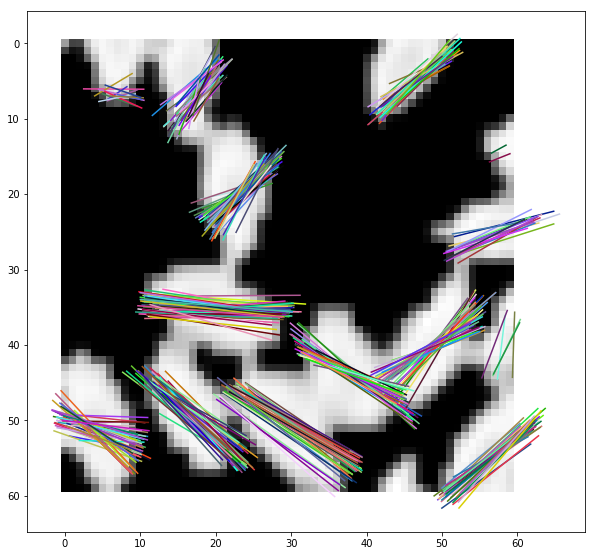

image


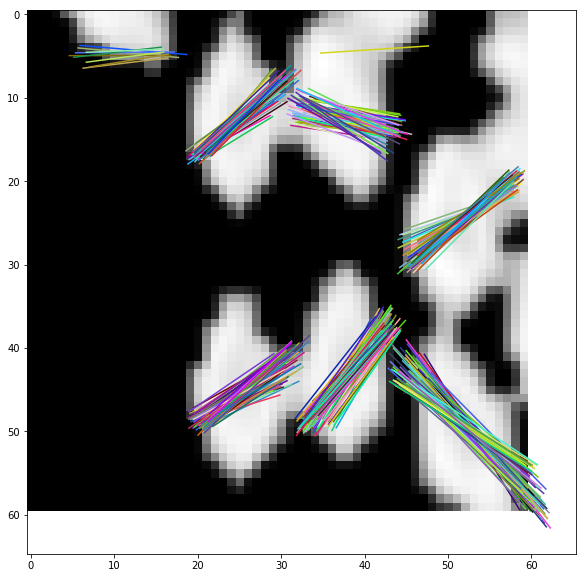

image


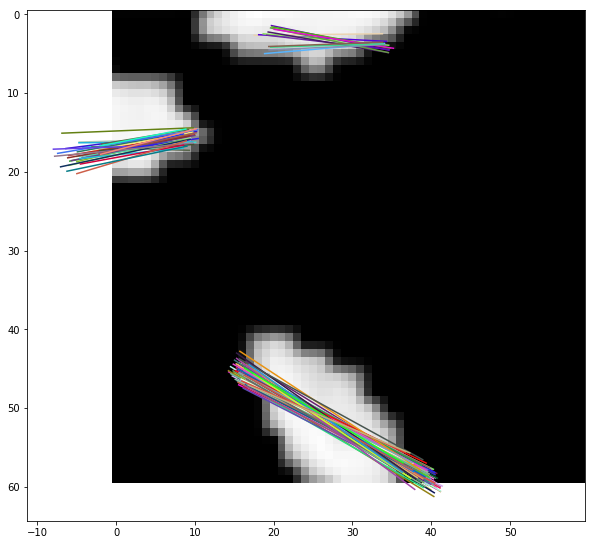

image


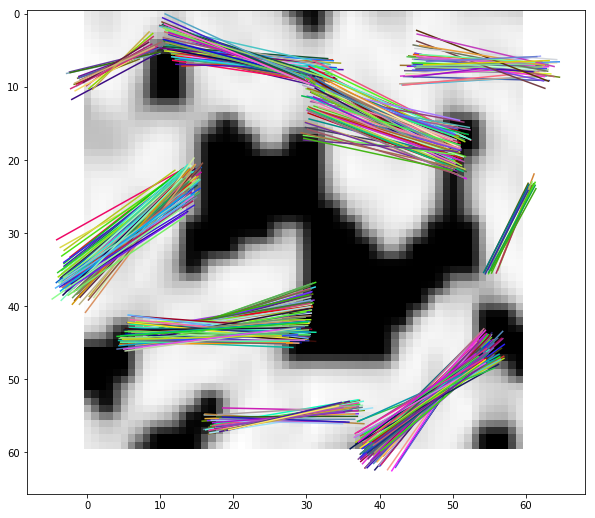

image


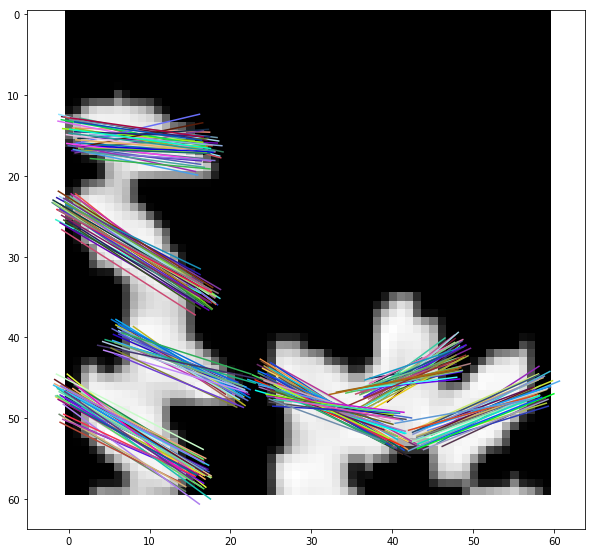

In [11]:
import matplotlib.pyplot as plt
import random

for vec, img, g in zip(vectors_batch, imgs_down, gt_class):
    # print(img.shape)
    
    plt.figure(figsize=(10,10))
    print('image')
    plt.imshow(img[0,:,:], cmap='Greys')
    
    # Add sorting code

    vec_subset =  vec#random.sample(vec, 80)
    
    for v in vec_subset: # Can also randomly sample vectors here
        a, v1, v2 = v
        
        #plt.plot(*v[0], *v[1], c=np.random.rand(3,))
        plt.plot([v1[0],v2[0] ],[v1[1],v2[1]],c=np.random.rand(3,))
    
    plt.show()

In [12]:
# some notes
# splits seem to be quite nice
# seems to be neatly splitting the beetle around 45